# README.

This notebook shows how to do some very basic analysis of the measurements.

In [1]:
%matplotlib inline
import dbutils
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import date
from time import mktime
import calendar


# Where to store outputs.
output_path = "."

# Connect to database.
main_connector = dbutils.connect_to_main_database()

# Getting the columns of the tables.

In [2]:
# Getting the tables.
sql_statement = "select * from information_schema.tables where table_schema != 'information_schema'"
results = main_connector.execute(sql_statement, fetch_all=True)
tables = [result[2] for result in results if result[1] == "public"]

# Getting the colums of the tables.
for table in tables:
    print(table, "\n\t", "\n\t".join(main_connector.get_columns(table)))

measurements 
	 id
	measurement_id
	person_id
	qrcode
	sex
	type
	age_days
	height_cms
	weight_kgs
	muac_cms
	head_circumference_cms
	oedema
	latitude
	longitude
	address
	timestamp
	deleted
	deleted_by
	visible
	created_by
image_data 
	 id
	path
	qrcode
	last_updated
	rejected_by_expert
	had_error
	error_message
	blur_variance
pointcloud_data 
	 id
	path
	qrcode
	last_updated
	rejected_by_expert
	had_error
	error_message
	number_of_points
	confidence_min
	confidence_avg
	confidence_std
	confidence_max
	centroid_x
	centroid_y
	centroid_z
	stdev_x
	stdev_y
	stdev_z
artifacts_with_targets 
	 qr_code
	artifact_id
	artifact_path
	type
	age
	height
	weight
	muac
	head_circumference
person 
	 id
	name
	surname
	birthday
	sex
	guardian
	is_age_estimated
	qr_code
	created
	timestamp
	created_by
	deleted
	deleted_by
measure 
	 id
	person_id
	date
	type
	age
	height
	weight
	muac
	head_circumference
	artifact
	visible
	oedema
	timestamp
	created_by
	deleted
	deleted_by
artifact 
	 id
	measure_id

# Simple analytics.

In [9]:
main_connector = dbutils.connect_to_main_database()

sql_statement = "SELECT COUNT(*) FROM measure;"
result = main_connector.execute(sql_statement, fetch_all=True)[0][0]
print(result, "measures")

sql_statement = "SELECT COUNT(*) FROM artifact WHERE type='rgb';"
result = main_connector.execute(sql_statement, fetch_all=True)[0][0]
print(result, "images")

sql_statement = "SELECT COUNT(*) FROM artifact WHERE type='pcd';"
result = main_connector.execute(sql_statement, fetch_all=True)[0][0]
print(result, "pointclouds")
   
sql_statement = "SELECT COUNT(*) FROM artifact;"
result = main_connector.execute(sql_statement, fetch_all=True)[0][0]
print(result, "artifacts")

sql_statement = "SELECT COUNT(*) FROM artifact WHERE measure_id IS NOT NULL;"
result = main_connector.execute(sql_statement, fetch_all=True)[0][0]
print(result, "artifacts with measure")

sql_statement = "SELECT COUNT(*) FROM artifact WHERE measure_id IS NULL;"
result = main_connector.execute(sql_statement, fetch_all=True)[0][0]
print(result, "artifacts without measure")
    
sql_statement = "SELECT SUM(file_size) FROM artifact;"
result = main_connector.execute(sql_statement, fetch_all=True)[0][0]
print(int(result / (1024 * 1024 * 1024)), "GBs")

sql_statement = "SELECT COUNT(DISTINCT(qr_code)) FROM artifact;"
result = main_connector.execute(sql_statement, fetch_all=True)[0][0]
print(result, "QR codes")

sql_statement = "SELECT COUNT(DISTINCT(qr_code)) FROM artifact WHERE measure_id IS NULL;"
result = main_connector.execute(sql_statement, fetch_all=True)[0][0]
print(result, "QR codes without measure_id")



13739 measures
743562 images
223249 pointclouds
966811 artifacts
633915 artifacts with measure
332896 artifacts without measure
378 GBs
5215 QR codes
1841 QR codes without measure_id


# Getting statistical values of measurements.

In [3]:
columns = [
 'age',
 'height',
 'weight',
 'muac',
 'head_circumference',
]

headers = []
rows = []
for column in columns:
    sql_statement = "SELECT MIN({0}), AVG({0}), MAX({0}) FROM measure;".format(column)
    minimum, average, maximum = main_connector.execute(sql_statement, fetch_one=True)
    
    rows.append([column, minimum, average, maximum])
    
headers = ("key", "minimum", "average", "maximum")
df = pd.DataFrame(rows, columns=headers)
df

,key,minimum,average,maximum
0,age,0.0,1098.1582356794526530,17834.0
1,height,0.0,43.4181,997.9
2,weight,0.0,5.53544,714.6
3,muac,0.0,7.08521,170.0
4,head_circumference,0.0,23.1865,446.0


In [4]:
max_age_days = 6 * 30
sql_statement = ""
sql_statement += "SELECT COUNT(*) FROM measure"
sql_statement += " WHERE age < {}".format(max_age_days)
sql_statement += " AND type=\'manual\'"
main_connector.execute(sql_statement, fetch_one=True)

(48,)

# Creating pie charts for some columns.

('cgm11whh@gmail.com',) 2637
('cgm13whh@gmail.com',) 1340
('cgm10whh@gmail.com',) 1339
('cgm16whh@gmail.com',) 1274
('cgm2whh@gmail.com',) 1248
('cgm15whh@gmail.com',) 1185
('cgm14whh@gmail.com',) 1067
('cgm9whh@gmail.com',) 1003
('cgm12whh@gmail.com',) 697
('pushpa.paswan.fhf@gmail.com',) 635
('cgm1whhinnovation@gmail.com',) 465
('cgm8whh@gmail.com',) 455
('cgm7whh@gmail.com',) 312
('nan',) 67
('mmatiaschek@gmail.com',) 12
('cgm6whh@gmail.com',) 3
(False,) 13736
(True,) 3


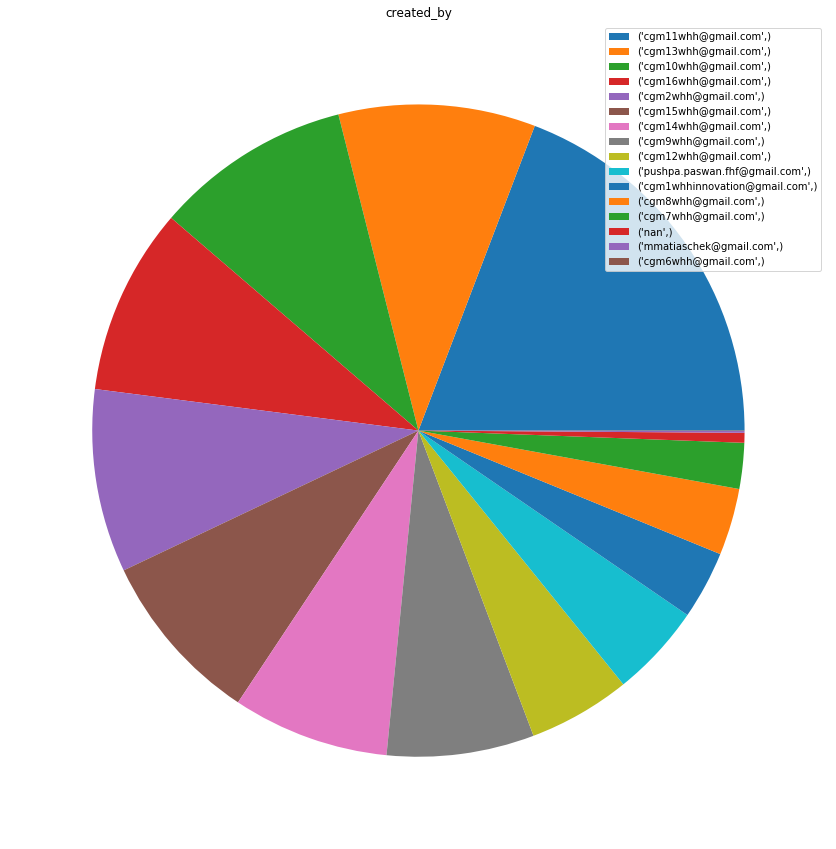

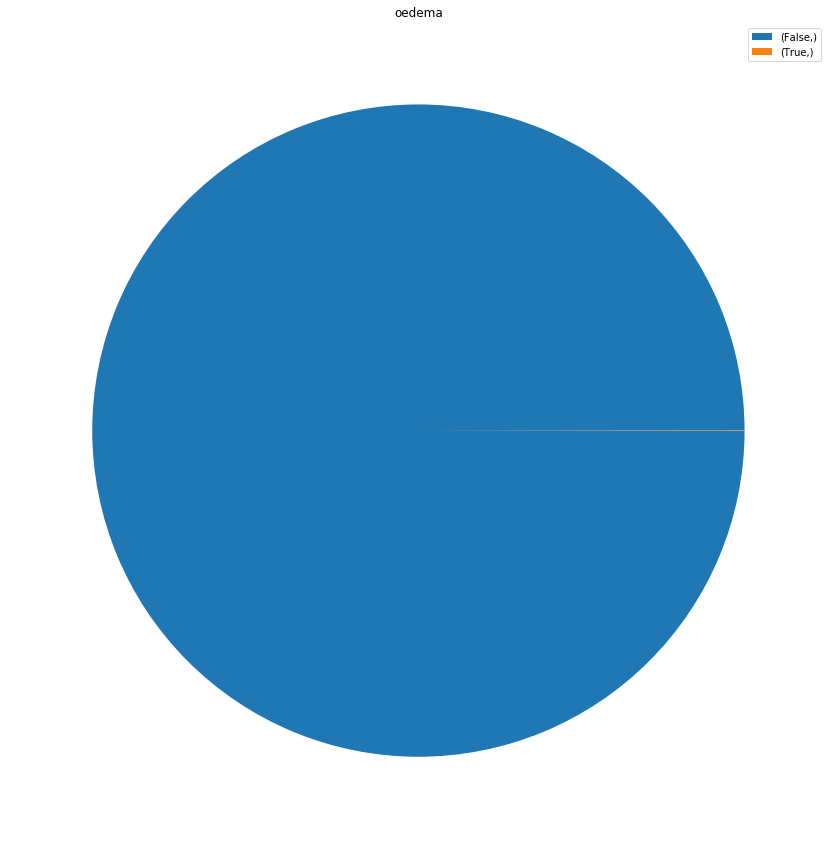

In [5]:
from collections import Counter

def make_pie(key):
    sql_statement = "SELECT {} FROM measure;".format(key)
    values_list = main_connector.execute(sql_statement, fetch_all=True)

    most_common = Counter(values_list).most_common(10000)

    # TODO percent
    values = []
    keys = []
    for key, value in most_common:
        print(key, value)
        keys.append(str(key))
        values.append(value)
        
    plt.figure(figsize=(15, 15))
    patches, texts = plt.pie(values)
    plt.legend(patches, keys)
    plt.title(df_key)
    plt.savefig(os.path.join(output_path, "pie-{}.png".format(df_key)))

    
df_keys = ["created_by", "oedema"]
for df_key in df_keys:
    make_pie(df_key)

# Render histograms.

[1371, 1104, 617, 707, 608, 1586, 1241, 1288, 345, 1241]


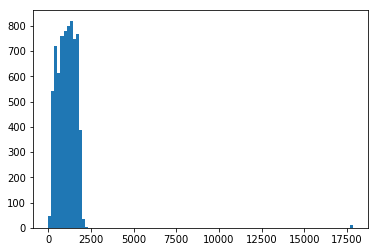

[90.5, 85.4, 76.3, 74.0, 71.0, 93.0, 76.9, 94.8, 68.3, 76.9]


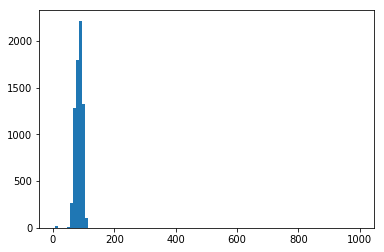

[10.7, 9.75, 8.2, 7.3, 7.65, 11.4, 76.9, 11.0, 8.0, 7.6]


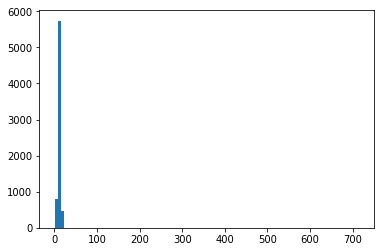

[13.5, 14.1, 13.5, 11.6, 12.6, 14.0, 12.3, 13.2, 13.1, 12.3]


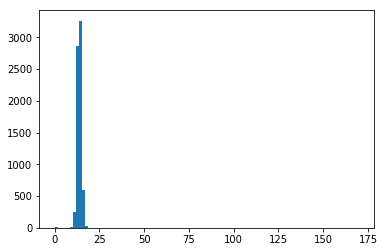

In [6]:
def render_histogram(key, values, bins):
    hist = plt.hist(values, bins=bins)
    plt.savefig("histogram-{}.png".format(key))
    plt.show()
    
render_parameters = []
render_parameters.append(("age", 100))
render_parameters.append(("height", 100))
render_parameters.append(("weight", 100))
render_parameters.append(("muac", 100))
for key, bins in render_parameters:
    sql_statement = "SELECT {} FROM measure WHERE type='manual'".format(key)
    results = main_connector.execute(sql_statement, fetch_all=True)
    values = [result[0] for result in results]
    print(values[0:10])
    render_histogram(key, values, bins)

# Rendering the measurements over time.

No handles with labels found to put in legend.


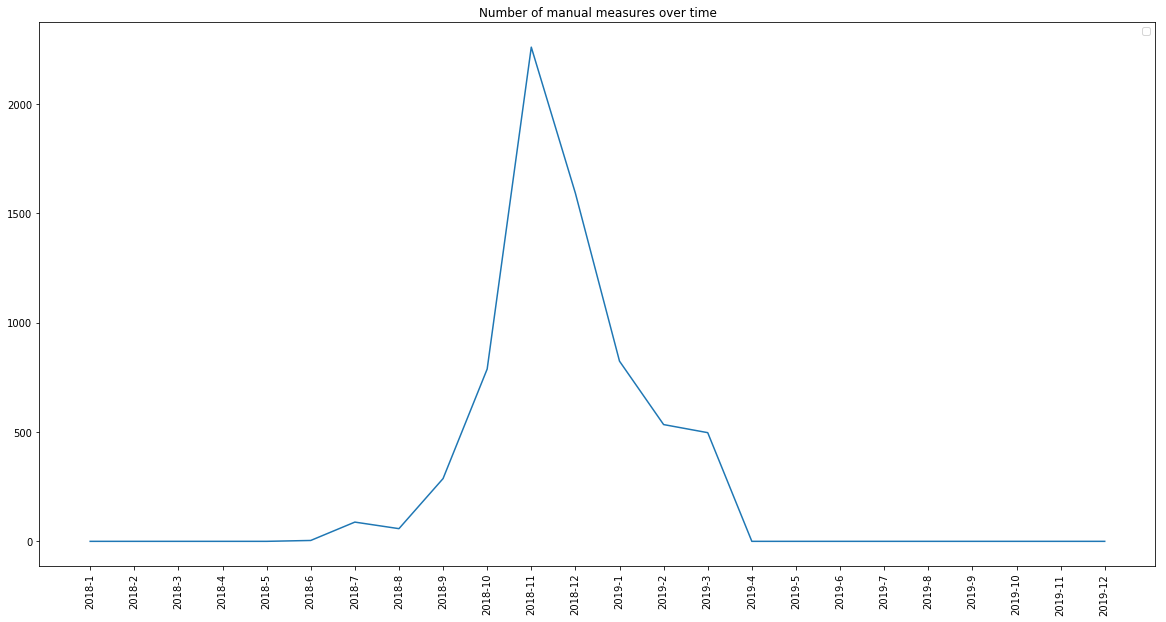

In [7]:
plot_values = []
plot_labels = []
for year in [2018, 2019]:
    for month in range(1, 13):
        
        # Getting the start.
        start_day = 1
        start_date = date(year, month, start_day)
        start_timestamp = str(1000 * int(mktime(start_date.timetuple())))
        
        # Getting the end.
        _, end_day = calendar.monthrange(year, month)
        end_date = date(year, month, end_day)
        end_timestamp = str(1000 * int(mktime(end_date.timetuple())))

        # Getting the number of entries from the database.
        sql_statement = ""
        sql_statement += "SELECT COUNT(*) FROM measure"
        sql_statement += " WHERE type='manual'"
        sql_statement += " AND timestamp >= {}".format(start_timestamp)
        sql_statement += " AND timestamp <= {}".format(end_timestamp)
        number_of_entries = main_connector.execute(sql_statement, fetch_one=True)[0]
        
        # Prepare the plot.
        plot_values.append(number_of_entries)
        plot_labels.append("{}-{}".format(year, month))
        
# Plot the plot.
plt.figure(figsize=(20,10))
plt.plot(plot_values)
plt.xticks(range(len(plot_labels)), plot_labels, rotation='vertical')
plt.legend()
plt.title("Number of manual measures over time")
plt.show()
plt.close()

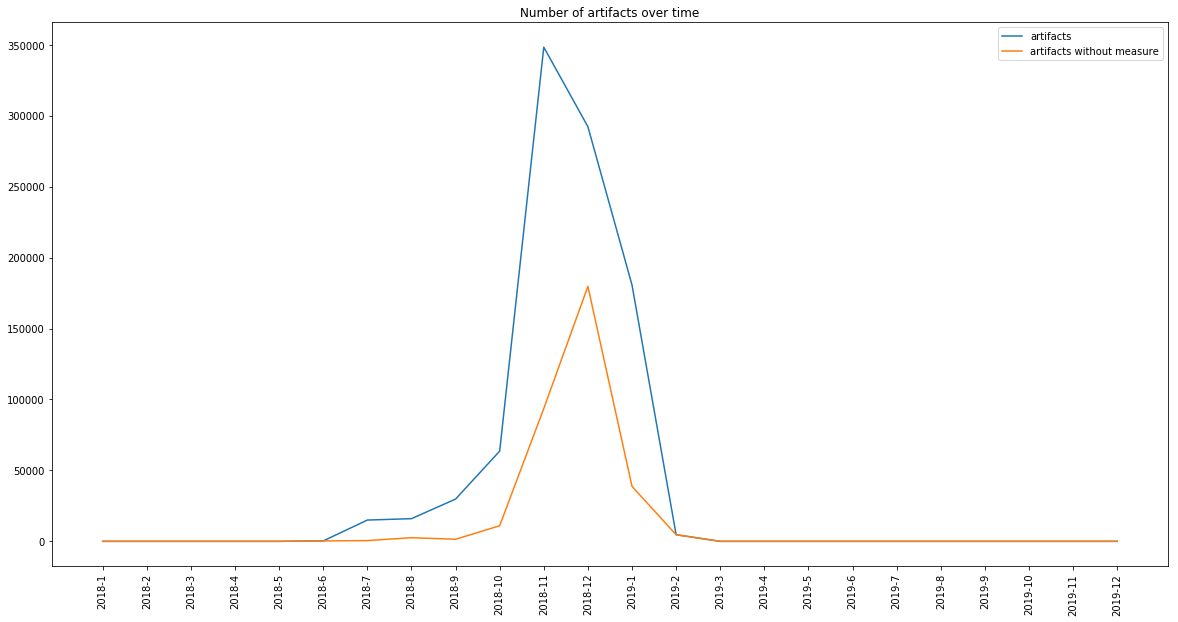

In [8]:
plot_values = []
plot_values_no_measure = []
plot_labels = []
for year in [2018, 2019]:
    for month in range(1, 13):
        
        # Getting the start.
        start_day = 1
        start_date = date(year, month, start_day)
        start_timestamp = str(1000 * int(mktime(start_date.timetuple())))
        
        # Getting the end.
        _, end_day = calendar.monthrange(year, month)
        end_date = date(year, month, end_day)
        end_timestamp = str(1000 * int(mktime(end_date.timetuple())))

        # Getting the number of artifacts.
        sql_statement = ""
        sql_statement += "SELECT COUNT(*) FROM artifact"
        sql_statement += " WHERE create_date >= {}".format(start_timestamp)
        sql_statement += " AND create_date <= {}".format(end_timestamp)
        number_of_entries = main_connector.execute(sql_statement, fetch_one=True)[0]
        plot_values.append(number_of_entries)
        
        # Getting the number of artifacts without measures.
        sql_statement = ""
        sql_statement += "SELECT COUNT(*) FROM artifact"
        sql_statement += " WHERE create_date >= {}".format(start_timestamp)
        sql_statement += " AND create_date <= {}".format(end_timestamp)
        sql_statement += " AND measure_id IS NULL"
        number_of_entries = main_connector.execute(sql_statement, fetch_one=True)[0]
        plot_values_no_measure.append(number_of_entries)
        
        plot_labels.append("{}-{}".format(year, month))
        
# Plot the plot.
plt.figure(figsize=(20, 10))
plt.plot(plot_values, label="artifacts")
plt.plot(plot_values_no_measure, label="artifacts without measure")
plt.xticks(range(len(plot_labels)), plot_labels, rotation='vertical')
plt.legend()
plt.title("Number of artifacts over time")
plt.show()
plt.close()

# Available data in GBs.

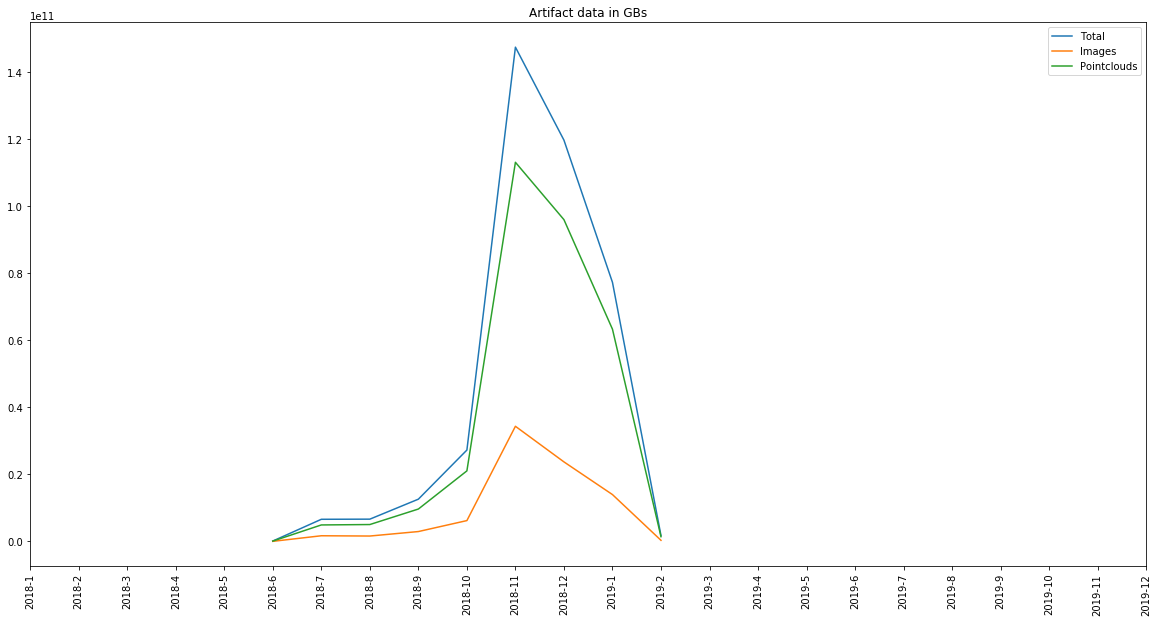

In [12]:
plot_values_total = []
plot_values_images = []
plot_values_pointclouds = []
plot_labels = []
for year in [2018, 2019]:
    for month in range(1, 13):
        
        # Getting the start.
        start_day = 1
        start_date = date(year, month, start_day)
        start_timestamp = str(1000 * int(mktime(start_date.timetuple())))
        
        # Getting the end.
        _, end_day = calendar.monthrange(year, month)
        end_date = date(year, month, end_day)
        end_timestamp = str(1000 * int(mktime(end_date.timetuple())))

        # Getting the overall filesize.
        sql_statement = ""
        sql_statement += "SELECT SUM(file_size) FROM artifact"
        sql_statement += " WHERE create_date >= {}".format(start_timestamp)
        sql_statement += " AND create_date <= {}".format(end_timestamp)
        number_of_entries = main_connector.execute(sql_statement, fetch_one=True)[0]
        plot_values_total.append(number_of_entries)
        
        # Getting the overall filesize.
        sql_statement = ""
        sql_statement += "SELECT SUM(file_size) FROM artifact"
        sql_statement += " WHERE create_date >= {}".format(start_timestamp)
        sql_statement += " AND create_date <= {}".format(end_timestamp)
        sql_statement += " AND type='rgb'"
        number_of_entries = main_connector.execute(sql_statement, fetch_one=True)[0]
        plot_values_images.append(number_of_entries)
        
        # Getting the overall filesize.
        sql_statement = ""
        sql_statement += "SELECT SUM(file_size) FROM artifact"
        sql_statement += " WHERE create_date >= {}".format(start_timestamp)
        sql_statement += " AND create_date <= {}".format(end_timestamp)
        sql_statement += " AND type='pcd'"
        number_of_entries = main_connector.execute(sql_statement, fetch_one=True)[0]
        plot_values_pointclouds.append(number_of_entries)

        # Labels
        plot_labels.append("{}-{}".format(year, month))
        
# Plot the plot.
plt.figure(figsize=(20,10))
plt.plot(plot_values_total, label="Total")
plt.plot(plot_values_images, label="Images")
plt.plot(plot_values_pointclouds, label="Pointclouds")
plt.xticks(range(len(plot_labels)), plot_labels, rotation='vertical')
plt.legend()
plt.title("Artifact data in GBs")
plt.show()
plt.close()

No handles with labels found to put in legend.


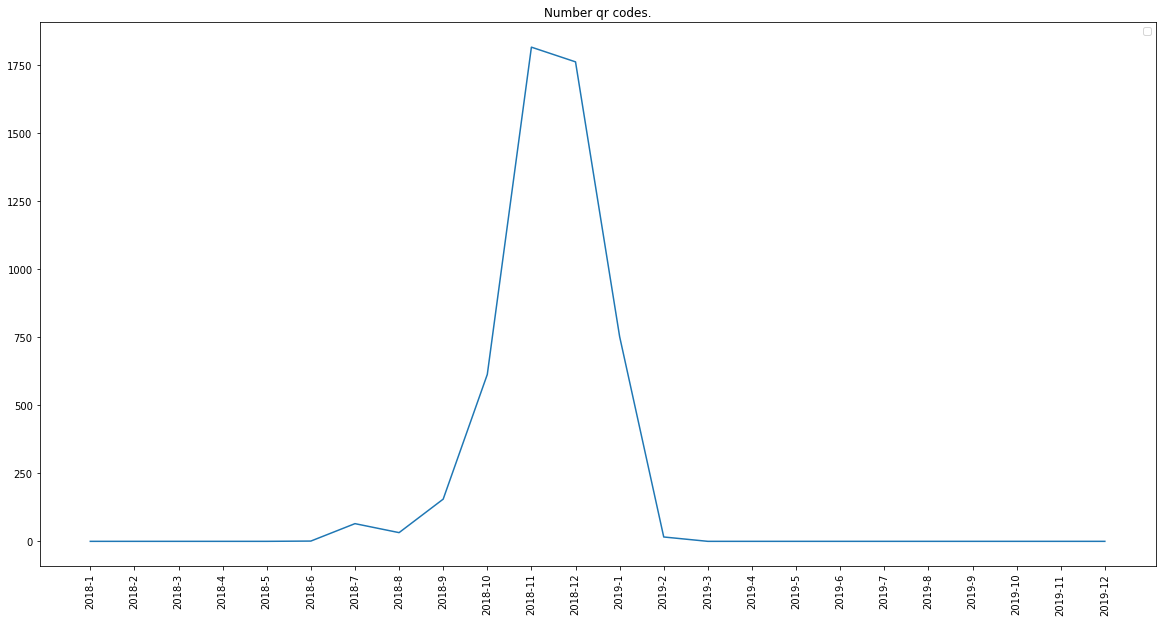

In [14]:
plot_values = []
plot_labels = []
for year in [2018, 2019]:
    for month in range(1, 13):
        
        # Getting the start.
        start_day = 1
        start_date = date(year, month, start_day)
        start_timestamp = str(1000 * int(mktime(start_date.timetuple())))
        
        # Getting the end.
        _, end_day = calendar.monthrange(year, month)
        end_date = date(year, month, end_day)
        end_timestamp = str(1000 * int(mktime(end_date.timetuple())))

        # Getting the number of entries from the database.
        sql_statement = ""
        sql_statement += "SELECT COUNT(DISTINCT(qr_code)) FROM artifact"
        sql_statement += " WHERE create_date >= {}".format(start_timestamp)
        sql_statement += " AND create_date <= {}".format(end_timestamp)
        number_of_entries = main_connector.execute(sql_statement, fetch_one=True)[0]
        
        # Prepare the plot.
        plot_values.append(number_of_entries)
        plot_labels.append("{}-{}".format(year, month))
        
# Plot the plot.
plt.figure(figsize=(20,10))
plt.plot(plot_values)
plt.xticks(range(len(plot_labels)), plot_labels, rotation='vertical')
plt.legend()
plt.title("Number qr codes.")
plt.show()
plt.close()